<a href="https://colab.research.google.com/github/karthikm15/Semi-Supervised-GANs-For-Melanoma-Detection/blob/main/MNIST_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import matplotlib.pyplot as plt # for plotting the images
%matplotlib inline

import numpy as np

import torch
from torch.utils.data import DataLoader, Dataset

# !pip uninstall torchvision -y
# !pip install torchvision
# !pip3 install https://download.pytorch.org/whl/cu100/torch-1.0.1.post2-cp35-cp35m-linux_x86_64.whl
# !pip3 install torchvision

import torchvision
from __future__ import print_function
import argparse
import torch
import torch.nn as nn # for building the neural network
import torch.nn.functional as F # for building the neural network
import torch.optim as optim # for building the neural network
from torchvision import datasets, transforms
from torch.autograd import Variable

In [47]:
if torch.cuda.is_available():
   print("Your Colab notebook is configured to run on the GPU!")
else:
   print("If you see this message, your Colab notebook is currently running on the CPU. Click the Runtime dropdown menu, select Change runtime type, and  choose GPU in the list of Hardware accelerators")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Your Colab notebook is configured to run on the GPU!


In [48]:
n_epochs = 3 # number of epochs that the model will be trained on
batch_size_train = 64 # how many images will be run at a time when the model is training
batch_size_test = 1000 # how many images will be run at a time when the model is being tested
learning_rate = 0.01 # to measure how fast the model performs gradient descent to reach the global minimum
momentum = 0.5 # Using momentum so that the gradient descent algoirthm doesn't get caught in local minima
log_interval = 10 # Logarithm interval for scaling hyperparameters up and down

random_seed = 1 # For repeating experiments, have to initialize random seeds for anything with random number gneration (including numpy and random)
torch.backends.cudnn.enabled = False # cuDNN uses nondeterministic algorithms (algorithms that will produce a different output for the same input) which can be disabled
torch.manual_seed(random_seed)

In [49]:
# Loading the training data for MNIST - using a batch size of 64 as shown above
# mean - 0.1307 and standard deviation - 0.3081 (global values chosen fo the MNIST dataset)
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

# Loading the testing data for MNIST - using a batch size of 1000 as shown above
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

# Interesting features in PyTorch that can be additionally implemented - other options beside dataset and batch size
# Example: set num_workers > 1 to use subprocesses to asynchronously load data or use pinned RAM speed up RAM using GPU transfers

In [50]:
# Looking at some examples using enumerate() and next()
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

print(example_targets)

tensor([4, 4, 2, 1, 8, 8, 2, 8, 3, 8, 5, 5, 5, 3, 0, 3, 6, 3, 0, 7, 0, 7, 2, 3,
        3, 4, 8, 2, 6, 1, 1, 2, 9, 5, 8, 2, 0, 3, 2, 3, 9, 9, 9, 3, 7, 9, 5, 7,
        2, 1, 6, 7, 2, 9, 3, 1, 3, 2, 0, 4, 8, 7, 5, 2, 4, 6, 5, 3, 9, 8, 9, 6,
        2, 8, 3, 9, 5, 9, 5, 0, 0, 4, 0, 2, 3, 0, 2, 8, 5, 8, 2, 2, 1, 3, 1, 5,
        1, 7, 2, 8, 8, 4, 2, 2, 9, 3, 1, 1, 4, 7, 2, 8, 7, 6, 2, 7, 6, 3, 6, 1,
        9, 0, 9, 7, 7, 9, 4, 0, 9, 4, 0, 2, 0, 7, 5, 9, 0, 4, 6, 7, 9, 4, 2, 4,
        0, 1, 2, 1, 4, 9, 3, 5, 3, 7, 8, 8, 3, 8, 5, 9, 1, 8, 3, 6, 8, 3, 3, 8,
        1, 6, 7, 4, 3, 3, 5, 6, 9, 6, 0, 2, 5, 1, 8, 0, 1, 4, 1, 1, 1, 7, 2, 7,
        1, 1, 0, 4, 7, 2, 4, 6, 1, 4, 3, 6, 2, 7, 5, 4, 1, 3, 3, 3, 4, 7, 8, 0,
        4, 3, 5, 8, 9, 4, 1, 9, 4, 7, 7, 1, 9, 6, 0, 4, 2, 9, 2, 1, 3, 6, 6, 0,
        2, 2, 0, 0, 2, 5, 8, 9, 7, 0, 0, 9, 2, 0, 9, 2, 6, 9, 9, 5, 4, 3, 2, 9,
        9, 4, 3, 5, 1, 3, 8, 5, 8, 4, 9, 5, 1, 4, 4, 6, 0, 7, 6, 8, 8, 8, 0, 9,
        8, 4, 5, 9, 4, 6, 3, 9, 9, 4, 5,

In [51]:
example_data.shape # Have 1000 examples of 28x28 pixels in grayscale images

torch.Size([1000, 1, 28, 28])

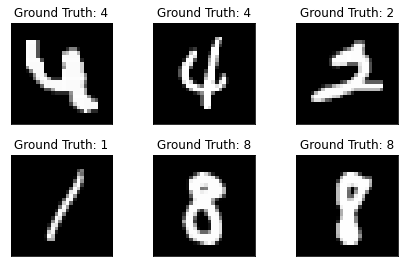

In [52]:
# Plots the first six images with the subsequent ground truth value at the top

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [53]:
# Building a neural network with two 2-D convolutional layers and two fully-connected/linear layers
# Choosing ReLU as an activation function 
# Two dropout layers for regularization - to prevent overfitting
class Net(nn.Module):
    def __init__(self):  # defining the layers for the neural network in general
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) # convolutional layer - one input nodes, ten output nodes, with a kernel size of five
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) # convolutional layer - ten input nodes, twenty output nodes, with a kernal size of five
        self.conv2_drop = nn.Dropout2d() # dropout - to prevent overfitting - randomly drops inputs from this layer
        self.fc1 = nn.Linear(320, 50) # 1D tensor - from 320 input nodes to 50 output nodes
        self.fc2 = nn.Linear(50, 10) # 1D tensor - from 50 input nodes to 10 output nodes

    def forward(self, x): # defines how we compute our output using the given layers and funcions
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) # ReLU activation function - take self.conv1(x) as rows and 2 as the column
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) # ReLU activation function - take self.conv2(x) as row (with dropout) and 2 as the column
        x = x.view(-1, 320) # reshapes the tensor so that it's -1 for rows (doesn't know the number of rows) and 320 for the number of columns
        x = F.relu(self.fc1(x)) # Applying the ReLU activation function to the linear function
        x = F.dropout(x, training=self.training) # Reducing overfitting on the linear model rather than the 2D model
        x = self.fc2(x) # Simply just runs the function again
        return F.log_softmax(x) # Gives each output decimal probabilities to easily distinguish the greatest one



In [54]:
network = Net() # initializing the network
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum) # initializing the optimizer
# To use GPUs - send the network parameters to GPU using network.cuda()

In [55]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [56]:
def train(epoch):
  network.train() # tells the model that you are training the model, not testing it
  for batch_idx, (data, target) in enumerate(train_loader): # batch_idx = the index that batch is currently on
    optimizer.zero_grad() # manually setting all of the gradeints to 0 - since PyTorch by default accumulates gradients
    output = network(data) # Feedforward through the network
    loss = F.nll_loss(output, target) # Can use the loss function to calculate the loss compared to the target
    loss.backward() # Uses backwards propagation through the network
    optimizer.step() # Updates the weights in the network
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item()) # appending the losses to an array
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './results/model.pth') # saving the model, .state_dict() allows it save and load their internal state
      torch.save(optimizer.state_dict(), './results/optimizer.pth') # saving the optimizer
      # can continue training from previosuly saved state dicts - .load_state_dict(state_dict)

In [57]:
def test():
  network.eval() # Tells the model that you are testing the model
  test_loss = 0
  correct = 0
  with torch.no_grad(): # no_grad() avoids storing computations done producing the output of our network in the computation graph
    for data, target in test_loader: 
      output = network(data) # does a feedforward through the network
      test_loss += F.nll_loss(output, target, size_average=False).item() # calculates the loss of the function
      pred = output.data.max(1, keepdim=True)[1] # It finds the probability that is the highest in outputs and stores it in prediction
      correct += pred.eq(target.data.view_as(pred)).sum() # 
  test_loss /= len(test_loader.dataset) # averages the test loss over all the images in the array
  test_losses.append(test_loss) # appends the test_losses to array
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [58]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3089, Accuracy: 674/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.368649
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.298366
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.294433
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.260970
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.295450
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.239506
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.274136
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.225711
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.168033
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.138118
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.061368
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.945130
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.949193
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.750880
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.642634
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.585531
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.416778
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.314595
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.256788
Train Epoch: 1 [12160/6

Text(0, 0.5, 'negative log likelihood loss')

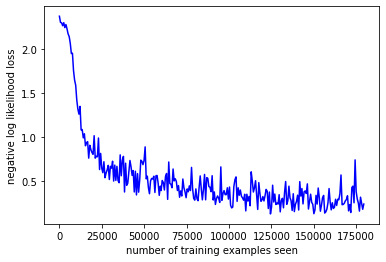

In [59]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

Text(0, 0.5, 'negative log likelihood loss')

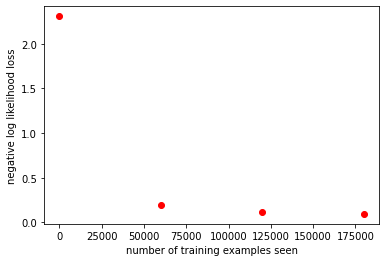

In [60]:
fig = plt.figure()
plt.scatter(test_counter, test_losses, color='red')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


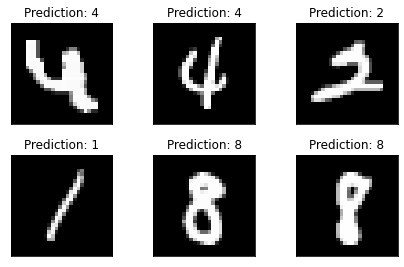

In [61]:
with torch.no_grad():
  output = network(example_data)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])

In [62]:
# Continuing training from checkpoints

# Initialize a new set of network and optimizers
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

network_state_dict = torch.load('./results/model.pth')
continued_network.load_state_dict(network_state_dict) # can load the internal state of network when last saved them

optimizer_state_dict = torch.load('./results/optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict) # can load the internal state of optimizers when last saved them

In [63]:
# Example showing that training loop can immediately pick up training when left it
# for i in range(4,9):
#   test_counter.append(i*len(train_loader.dataset))
#   train(i)
#   test()